Lord of the Rings Wiki Scraping

In [1]:
# Various imports
import json
import os
import re
import wikipedia
import wikia
import unicodedata
import matplotlib.pyplot as plt
from ast import literal_eval
import requests
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import scipy.stats as scipy
import wordcloud
import seaborn
from adjustText import adjust_text
from numpy.polynomial.polynomial import polyfit

In [2]:
os.getcwd()
os.chdir("C:\\Users\\aamar\\Downloads")
words = pd.read_csv("WordsbyCharacter.csv")
words.head(5)

,Film,Chapter,Character,Race,Words
0,The Fellowship Of The Ring,01: Prologue,Bilbo,Hobbit,4
1,The Fellowship Of The Ring,01: Prologue,Elrond,Elf,5
2,The Fellowship Of The Ring,01: Prologue,Galadriel,Elf,460
3,The Fellowship Of The Ring,01: Prologue,Gollum,Gollum,20
4,The Fellowship Of The Ring,02: Concerning Hobbits,Bilbo,Hobbit,214


In [3]:
words.describe(include = 'all')

,Film,Chapter,Character,Race,Words
count,731,731,731,731,731.000000
unique,3,188,74,10,NaN
top,The Return Of The King,27: The Council Of Elrond,Aragorn,Men,NaN
freq,268,12,61,240,NaN
mean,NaN,NaN,NaN,NaN,43.733242
std,NaN,NaN,NaN,NaN,57.492429
min,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,NaN,9.000000
50%,NaN,NaN,NaN,NaN,24.000000
75%,NaN,NaN,NaN,NaN,56.000000


In [4]:
words["Character"].unique()

array(['Bilbo', 'Elrond', 'Galadriel', 'Gollum', 'Frodo', 'Gandalf',
       'Hobbit Kids', 'Hobbits', 'Lobelia Sackville-Baggins', 'Merry',
       'Mrs. Bracegirdle', 'Pippin', 'Proudfoot', 'Sam', 'Nazgul',
       'Gaffer', 'Rosie', 'Sandyman', 'Ted', 'Saruman', 'Farmer Maggot',
       'Aragorn', 'Gatekeeper', 'Innkeeper', 'Man', 'Voice Of The Ring',
       'Orc', 'Voice Of Sauron', 'Arwen', 'Isildur', 'Boromir', 'Gimli',
       'Legolas', 'Haldir', 'Celeborn', 'Lurtz', 'Smeagol', 'Grishnakh',
       'Mauhur', 'Ugluk', 'Eothain', 'Freda', 'Morwen', 'Wild Man',
       'Eomer', 'Rohan Warrior', 'Eowyn', 'Grima Wormtongue', 'Theoden',
       'Uruk-hai', 'Treebeard', 'Hama', 'Faramir', 'Gamling', 'Snaga',
       'Rohan Maiden', 'Gondor Man', 'Crowd', 'Denethor', 'Haleth',
       'Deagol', 'Figwit', 'Damrod', 'Gothmog', 'Madril', 'Irolas',
       'Witch King', 'Grimhold', 'King Of The Dead', 'Boson', 'Mercenary',
       'Shagrat', 'Grobag', 'Mouth Of Sauron'], dtype=object)

In [5]:
charwords = words[["Character","Words"]].groupby("Character").sum()
# Dropping randoms
charwords = charwords.drop(index = ["Crowd", "Boson", "Gatekeeper", "Mercenary", "Proudfoot", "Uruk-hai", "Orc", "Nazgul", \
                                    "Smeagol", "Man", "Rohan Maiden", "Rohan Warrior", "Hobbits", "Gondor Man", "Hobbit Kids",\
                                    "Wild Man", "Innkeeper"])
charwords = charwords.drop(index = ["Ted", "Voice Of The Ring", "Gaffer"])
# Fixing typos, fixing characters
charwords.rename(index={'Grimhold':'Grimbold'},inplace=True)
charwords.rename(index={'Haldir':'Haldir (Lorien)'},inplace=True)
charwords.rename(index={'Sandyman':'Ted Sandyman'}, inplace=True)
charwords.rename(index={'Mouth Of Sauron':'The Mouth of Sauron'},inplace=True)
charwords.rename(index={'King Of The Dead':'The King of the Dead'},inplace=True)
charwords.rename(index={'Grobag':'Gorbag'},inplace=True)
charwords.rename(index={'Voice Of Sauron':'Sauron'},inplace=True)
charwords.rename(index={'Gothmog':'Gothmog (Lieutenant of Morgul)'},inplace=True)
# Addding Sharku
charwords.loc["Sharku"] = charwords.loc["Frodo"]
charwords.loc["Sharku"] = 9
#Adding Lugdush
charwords.loc["Lugdush"] = charwords.loc["Frodo"]
charwords.loc["Lugdush"] = 12
charwords = charwords.sort_index()
charwords.head()

,Words
Character,
Aragorn,2322
Arwen,491
Bilbo,1366
Boromir,1077
Celeborn,160


In [6]:
pagelens = []
genders = []
import datetime 
def linkcontent():
    start = datetime.datetime.now()
    print("Starting scraping at " + str(start))
    for i in charwords.index:
        link = requests.get(str('http://lotr.wikia.com/wiki/' + str(i)))
        url = str(link.url).replace("%", r"\x")
        urld = literal_eval("b'{}'".format(url)).decode('utf8')
        urld2 = urld.rsplit('/', 1)[-1]
        try:
            page = wikia.page("LOTR", urld2).content
            pagelen = len(page.split())
            pagelens.append(pagelen)
            male = wikia.page("LOTR", urld2).html().find("Male")
            female = wikia.page("LOTR", urld2).html().find("Female")
            if male >= 0 and female >= 0:
                genders.append("Error")
            elif male >= 0:
                genders.append("Male")
            elif female >= 0:
                genders.append("Female")
            else:
                print(str(i), " not found")
                genders.append("NaN")
            print(urld2, "Added")
        except:
            pagelens.append("NaN")
            print(urld2, ":", "Page not found")
    end = datetime.datetime.now()
    print("Done at ", str(end))
linkcontent()
charwords["Page Length"] = pagelens
charwords["Gender"] = genders

Starting scraping at 2019-09-17 17:01:50.503058
Aragorn_II_Elessar Added
Arwen Added
Bilbo_Baggins Added
Boromir Added
Celeborn Added
Damrod Added
Déagol Added
Denethor_II Added
Elrond Added
Eomer  not found
Éomer Added
Éothain Added
Éowyn Added
Faramir Added
Farmer_Maggot Added
Figwit Added
Freda Added
Frodo  not found
Frodo_Baggins Added
Galadriel  not found
Galadriel Added
Gamling Added
Gandalf Added
Gimli Added
Gollum Added
Gorbag Added
Gothmog_(Lieutenant_of_Morgul) Added
Gríma_Wormtongue Added
Grimbold Added
Grishnákh Added
Haldir_(Lorien) Added
Haleth Added
Háma Added
Irolas Added
Isildur Added
Legolas Added
Lobelia_Sackville-Baggins Added
Lugdush Added
Lurtz Added
Madril Added
Mauhúr Added
Merry  not found
Meriadoc_Brandybuck Added
Morwen Added
Mrs._Bracegirdle Added
Pippin  not found
Peregrin_Took Added
Rosie_Cotton Added
Samwise_Gamgee Added
Saruman Added
Sauron Added
Shagrat Added
Sharku Added
Snaga Added
Ted_Sandyman Added
The_King_of_the_Dead Added
Mouth_of_Sauron Added
Th

In [7]:
charwords.at['Frodo', 'Gender'] = "Male"
charwords.at['Merry', 'Gender'] = "Male"
charwords.at['Pippin', 'Gender'] = "Male"
charwords.at["Galadriel", "Gender"] = "Female"
charwords.at["Eomer", "Gender"] = "Male"


female = charwords[charwords["Gender"] == "Female"]
male = charwords[charwords["Gender"] == "Male"]

femwords = sum(female["Words"])
malwords = sum(male["Words"])
totalwords = femwords + malwords

femwords/totalwords

charwords.head(100)
np.corrcoef(male["Words"], male["Page Length"])
femcorr = round(list(np.corrcoef(female["Words"], female["Page Length"]))[0][1], 3)
malecorr = round(list(np.corrcoef(male["Words"], male["Page Length"]))[0][1], 3)


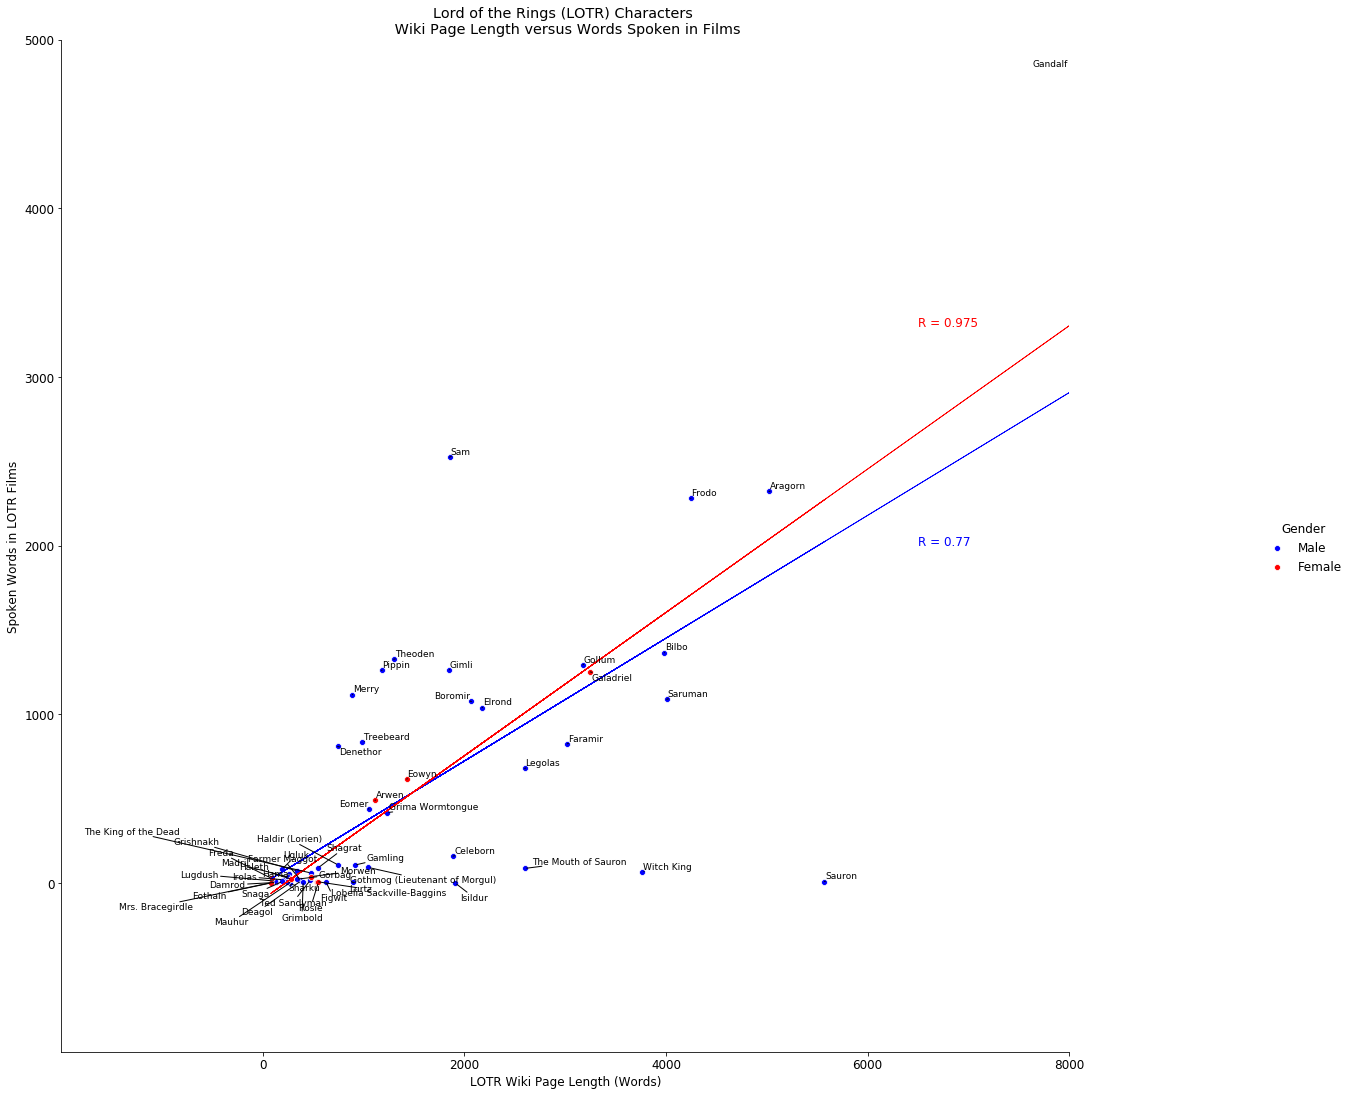

In [8]:
#plt.scatter(x = "Words", y = "Page Length", data = charwords, set_cmap= "Gender", s = 3)
plt.rcParams.update({'font.size': 12})
seaborn.pairplot(x_vars=["Page Length"], y_vars=["Words"], data=charwords, hue="Gender", height = 15, palette = ["blue","red"])
plt.title("Lord of the Rings (LOTR) Characters \n Wiki Page Length versus Words Spoken in Films", y = 10)
plt.xlabel("LOTR Wiki Page Length (Words)")
plt.ylabel("Spoken Words in LOTR Films")
y = charwords["Page Length"]
x = charwords["Words"]
plt.xlim(-2000, 8000)
plt.ylim(-1000, 5000)
plt.yticks([0, 1000, 2000, 3000, 4000, 5000])
plt.xticks([0, 2000, 4000, 6000, 8000])
b1, m1 = polyfit(male["Page Length"], male['Words'], 1)
plt.plot(charwords["Page Length"], b1 + m1 * charwords["Page Length"], '-', color = "blue", lw = "0.8")
b2, m2 = polyfit(female["Page Length"],female["Words"], 1)
plt.plot(charwords["Page Length"], b2 + m2 * charwords["Page Length"], '-', color = "red", lw = "0.8")
fstr = "R = " + str(femcorr)
mstr = "R = " + str(malecorr)
plt.annotate(fstr, xy = (6500,3300), color = "red")
plt.annotate(mstr, xy = (6500,2000), color = "blue")
texts = [plt.text(y[i], x[i], i, ha='center', va='center', size = 9) for i in list(charwords.index)]
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))
plt.savefig("LOTR.png")